# Solutions: nearest neighbors computation

This notebook contains practical exercise to manipulate the $k$ nearest neighbors of a particular observation under study, the so called **kNN aglorithm**, standing for *k Nearest Neighbor*.

## Import and pseudo-datasets

In [237]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [238]:
# Plot settings
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

The following piece of code create two reference dataset (*training*) containing 1 million observation, each observation consist of 25 variables (or *features*). For the purpose of the exercise, we use gaussian numbers with a mean of -3.5 and +3.5 for training dataset 1 and 2 respectively (both having a RMS of 5).

In [239]:
# Generation of two (training) datasets of 10e6 observations contanining 25 features each
Nobs = 1000000
trainX1 = 5.0*np.random.randn(Nobs,25) - 3.5
trainX2 = 5.0*np.random.randn(Nobs,25) + 3.5

Since our training dataset is known, it can be useful to consider labels associated to each event. This label is the property we might want to predict for a new, unknown observation. We decide to label `trainX1` with `1` and `trainX2` with `2`:

In [240]:
# Create the target (or label for each dataset)
trainY1 = np.zeros(Nobs)+1
trainY2 = np.zeros(Nobs)+2

## Quick data inspection

Plot and compare the distribution of the first variables for `dataX1` and `dataX2`

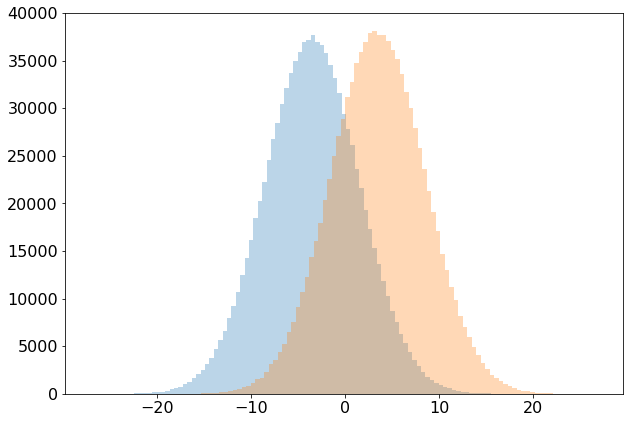

In [241]:
# Plotting the distributions of the first feature
plt.hist(trainX1[:, 0], bins=100, alpha=0.3)
plt.hist(trainX2[:, 0], bins=100, alpha=0.3);

## Nearest neighbors of a new observation `obs`

In [242]:
# compute distances for a test observation
obs = np.random.randn(25)
print(obs)

[ 0.66380053  1.01824852  0.9144033  -0.28665993  2.46102305  0.81671858
  0.60600825 -0.3177847   0.37788844 -0.71236478 -0.03941862 -0.50303335
  0.28992627 -0.65177336  0.29681329  0.77677139  0.3571817  -0.61964421
  0.77432164  1.70940417 -0.4413988  -0.73236376  0.26567096 -1.65081518
  0.87642   ]


### Merge the two datasets `X` and `Y`

The idea is to manipulate a single array `trainX` for the features regardless of the type of data (1 or 2), while keeping track of the label with a single `trainY` array:

In [243]:
trainX = np.concatenate([trainX1, trainX2])
trainY = np.concatenate([trainY1, trainY2])

### Compute the distance between `obs` and the global dataset

Using broadcasting and vectorized operation, compute the euclidien distance in the 25 dimension space between the unknown observation and every point of the global dataset (containing both data of type 1 and 2).

In [244]:
distances = np.sum((trainX-obs)**2, axis=1)**(0.5)

### Sort the distances to have the nearest points first

In this question, we want to sort distances by increasing order (to later take only the $k$ first ones), and the associated type of neighbors (1 or 2). 

**HINT:** this can be done using the function `np.argsort()`.

In [245]:
# Get the point indices by increasing distances
sorted_points = np.argsort(distances)

# Get the sorted distances
sdistances = distances[sorted_points]

# Get the corresponding data type
sorted_trainY = trainY[sorted_points]

### Vizualize the observation and its neighbors in a 2D projection

We would like to vizualize the observation and its 100 nearest neighbors in the 2D projection of the two first features. Produce a scatter plot showing the observation and the 100 nearest neighbors with different color for different types, and markersize depending on the 2D distance.

**HINT:** one can use fancy indexing, considering that `sorted_points[:100]` is the indices of the 100 nearest neighbors.

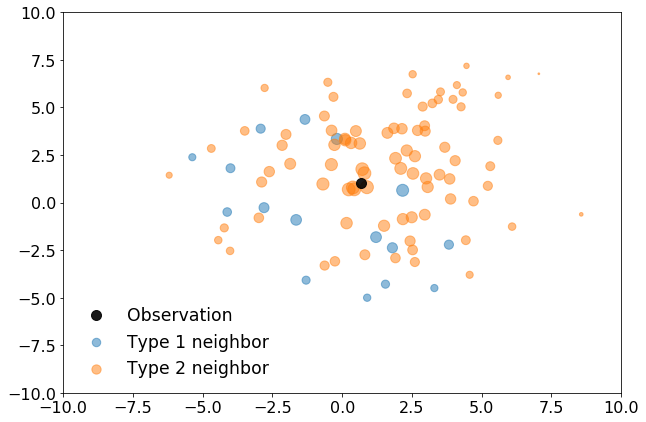

In [261]:
# Plot observation
xobs, yobs = obs[0], obs[1]
plt.scatter(xobs, yobs, color='black', alpha=0.9, s=100, zorder=3, label='Observation')

# Get the index of the k=100 first neighbors
idx = sorted_points[:100]

# Get data category, x and y values for those NN
typeNN, xNN, yNN = trainY[idx], trainX[idx, 0], trainX[idx, 1]

# Compute markersize depending on the 2D distances
dNN = np.sqrt( (xNN-xobs)**2 + (yNN-yobs)**2 )
markersize = 20*(np.max(dNN) - dNN)

# Get type 1 and type 2 data
type1, type2 = typeNN==1, typeNN==2

# Plot the result
plt.scatter(xNN[type1], yNN[type1], alpha=0.5, s=markersize[type1], label='Type 1 neighbor')
plt.scatter(xNN[type2], yNN[type2], alpha=0.5, s=markersize[type2], label='Type 2 neighbor')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend();

### Count the number of nearest neighbors of type 1 and type 2 

We would like to consider the k nearest neighbors, and count the fraction of type 1 and type 2 data (to later be able to say if our unknown observation is more likely to be of type 1 or 2). Of course, if we consider the whole training points (`k=Nobs`), there will be `Nobs` points of type 1 and `Nobs` points of type 2. This is why it is interesting to compute the number of type 1 and type 2 neihbors *as a function of k*. We will consider all k values from 1 to 500.

**HINT:** the function `np.cumsum()` might be useful.

In [162]:
# Get the number of neighbor type 1 and type 2 among the k nearest neighbor
Nb1 = np.cumsum(sorted_trainY==1)
Nb2 = np.cumsum(sorted_trainY==2)

# Consider only the k values from 1 to 500
Nb1 = Nb1[:500]
Nb2 = Nb2[:500]

Plot the number of neighbors of type 1 and type 2 as a function of $k$

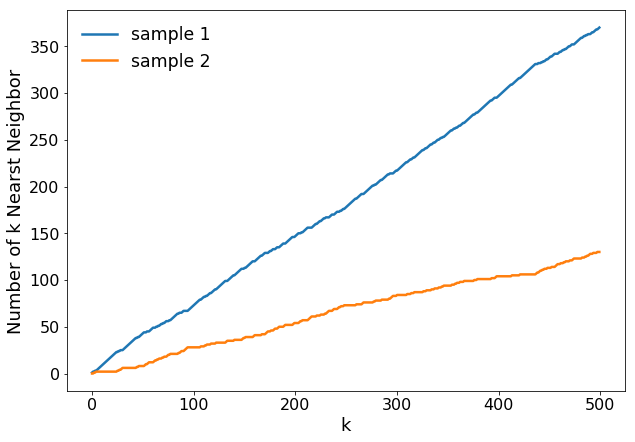

In [163]:
plt.plot(Nb1, label='sample 1')
plt.plot(Nb2, label='sample 2')
plt.ylabel('Number of k Nearst Neighbor')
plt.xlabel('k')
plt.legend();

### Create a function `get_kNN_obs()` doing all this at once

We want now to have a function taking in argument an observation, a training sample trainX and a target trainY *with an arbitray number of type of data*, which returns the number of nearest neighbors up to kmax for each data type (formated into a list). In other words, we want a function returning `[N1, N2, ... Nj]`, where `Ni` is numpy 1D array of shape `(kmax,)` containing the number of neighbor of type `i` among the `k` nearest neighbors -- up to `kmax`.

In [164]:
def get_kNN_obs(obs, trainX, trainY, kmax=500):
    
    '''
    Compute the number of nearest neighbors (up to kmax) of an 
    observation `obs` with a training sample `trainX` labled 
    with `trainY`.
    
    return [N1, N2, ... Nj] (list of neighbors number for each k<kmax)
    where Ni is a numpy 1D array of shape (kmax,) containing the number
    of neighbor of type i in the k nearest neighbors.
    '''
    
    # Compute distances
    r = np.sum((trainX-obs)**2, axis=1)**(0.5)
    
    # Sort the distances
    sorted_NN = np.argsort(r)
    sorted_trainY = trainY[sorted_NN]
    
    # Get a list of unique of labels
    labels = np.unique(trainY)
    
    # Loop over labels and count the number of  nearest neighbors
    res = [np.cumsum(sorted_trainY==l)[:kmax] for l in labels]
    
    # Return the array of number of nearest neighbor
    return res


def plot_kNN(kNN_array):
    for i, kNN in  enumerate(kNN_array):
        plt.plot(kNN, label='Sample {}'.format(i+1))
    plt.ylabel('Number of k Nearst Neighbors')
    plt.xlabel('k')
    plt.legend()
    return

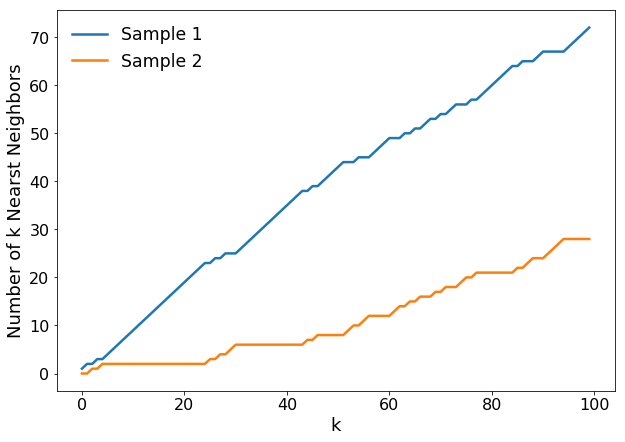

In [165]:
# Plot one observation
kNN = get_kNN_obs(obs, trainX, trainY, kmax=100)
plot_kNN(kNN)

## Nearest neighbors of a new set of unknown observations `testX`

### Preparing the proper broadcasting

In this part, we want to repeat the operation previously made for one observation, on an entire dataset. This is possible using broadcasting. What is the proper re-shaping in order to get an array of shape `(Nobs, Ntrain, Nvar)` from two arrays of shape `(Nobs, Nvar)` and `(Ntrain, Nvar)`? 

**HINT:** we can use the `a.reshape()` to add an *empty axis* at the right position.

In [166]:
d1 = np.random.randn(10, 3)
t1 = np.random.randn(5, 3)
# t1+d1 will crash with "could not be broadcast together with shapes (5,3) (10,3)"

### Generalize  `get_kNN_obs()` to run over a dataset

Here, we want a function returning `[N1, N2, ... Nj]`, where `Ni` is numpy *2D array* of shape `(Nobs, kmax)` containing the number of neighbor of type `i` among the `k` nearest neighbors - up to `kmax` - for each observation.

In [167]:
def get_kNN_data(dataX, trainX, trainY, kmax=500):
    
    '''
    Compute the number of nearest neighbors (up to kmax) of an 
    observation `o` for two sample `d1` and `d2`.
    
    return N1, N2 (array of neighbors in data1 and data2 in the kmax nearest ones)
    '''
    
    # Get some numbers (o must be a 2D array)
    nd, nv = dataX.shape[0], dataX.shape[1]
    nt = trainX.shape[0]
    
    # Prepare proper broadcasting
    trainX = trainX.reshape(1, nt, nv)
    dataX = dataX.reshape(nd, 1, nv)
    
    # Compute distances
    r = np.sum((trainX-dataX)**2, axis=2)**(0.5)
    
    # Sort the distances along distances
    sorted_NN = np.argsort(r, axis=1)
    sorted_trainY = trainY[sorted_NN]
    
    # Get the list of unique labels
    labels = np.unique(sorted_trainY)
    
    # Loop over labels and count the number of  nearest neighbors
    res = [np.cumsum(sorted_trainY==l, axis=1)[:, :kmax] for l in labels]
    
    # Return the array of number of nearest neighbor
    return res

### Generation of unknown pseudo-data

In [176]:
# Generate pseudo data like data1 and data2
data_obs_like1 = 3*np.random.randn(10000, 25) - 2.5
data_obs_like2 = 3*np.random.randn(10000, 25) + 2.5

### Memory limit - lazy *v.s* eager learner

This algorithm needs to loop over all training observation for each unknown observation. This is called a *lazy learner*, as opposed to the *eager learner* which can be evaluated for each unknown observation without the training sample. This might causes trouble in case of large dataset

In [177]:
get_kNN_data(data_obs_like1, trainX, trainY)

MemoryError: 

Write a function `kNNprediction(dataX, trainX, trainY, k, ntrain)` which takes only `ntrain` events of the training sample (equally sampled in the array, *i.e.* **not** the first `ntrain` elements of the training sample) and run the kNN computation.

**HINT:** it's recommanded to remain below a size of 1000000. Since our unknown dataset are have 10000 observations, it's better to not considere more than few 1000 training events.

In [178]:
def run_get_kNN(dataX, trainX, trainY, k=100, ntrain=1000):
    ntot = trainX.shape[0]
    s = int(ntot/ntrain)
    small_trainX, small_trainY = trainX[::s], trainY[::s]
    return get_kNN_data(dataX, small_trainX, small_trainY, k)

Call this function on both `data_obs_like1` and `data_obs_like2` and plot the fraction of k nearest neibghors of type 1 for each unknown dataset. Compare how the discriminative power changes with $k$.

In [182]:
# Compute the number of kNN for training1, training2
kmax = 500
obs1_N1, obs1_N2 = run_get_kNN(data_obs_like1, trainX, trainY, k=kmax)
obs2_N1, obs2_N2 = run_get_kNN(data_obs_like2, trainX, trainY, k=kmax)

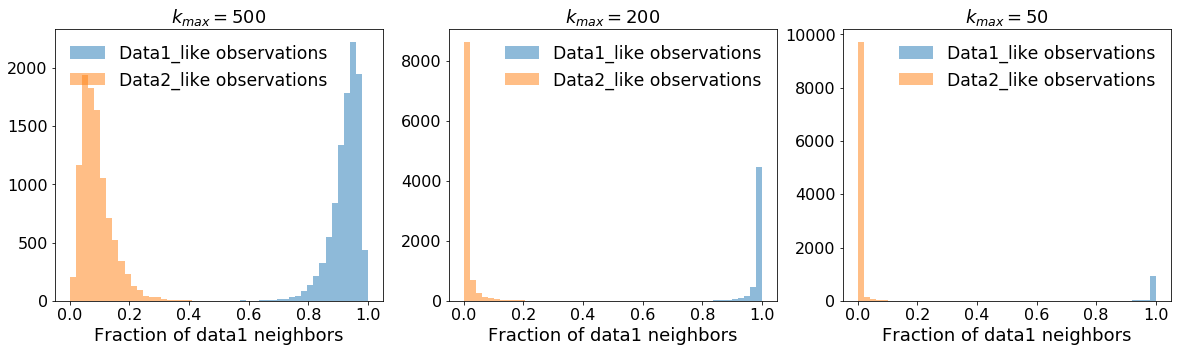

In [184]:
style = {'bins': np.linspace(0, 1, 50), 'alpha': 0.5}
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.hist(obs1_N1[:, -1]/kmax, **style, label='Data1_like observations')
plt.hist(obs2_N1[:, -1]/kmax, **style, label='Data2_like observations');
plt.xlabel('Fraction of data1 neighbors')
plt.title('$k_{max}=500$')
plt.legend();

plt.subplot(132)
plt.hist(obs1_N1[:, 200]/200, **style, label='Data1_like observations')
plt.hist(obs2_N1[:, 200]/200, **style, label='Data2_like observations');
plt.xlabel('Fraction of data1 neighbors')
plt.title('$k_{max}=200$')
plt.legend();

plt.subplot(133)
plt.hist(obs1_N1[:, 50]/50, **style, label='Data1_like observations')
plt.hist(obs2_N1[:, 50]/50, **style, label='Data2_like observations');
plt.xlabel('Fraction of data1 neighbors')
plt.title('$k_{max}=50$')
plt.legend();

## Computing the nearest neighbors with many categories

### Generation of a training dataset with 5 types of data

We first create a more complex dataset contanining 5 different populations stored in `trainX_ndata`, with five different averages. The associated labels are in `trainY_ndata`.

In [185]:
Nobs = 10000
mulist = [-5, -2, 0, 2, 5]
dlist = [5.0*np.random.randn(Nobs,25)+mu for mu in mulist]
llist = [np.zeros(Nobs)+i for i in np.arange(len(mulist))]

In [186]:
trainX_ndata = np.concatenate(dlist)
trainY_ndata = np.concatenate(llist)

### Number of neighbor of each population

The goal here is to have a function which return the number of neighbors for each population among the $k$ nearest neighbors. In otherwords, we want the composition of the $k$ nearest neighbors.

**HINT:** Since the number and the nature of label is *a priori* unknown, it might be convenient to store the information into a dictionnary `{label: n_kNN_label}`

In [187]:
def get_kNN_composition(dataX, trainX, trainY, k=500):
    
    '''
    Compute the number of nearest neighbors (up to k) on a data sample 
    `d` for a traning sample `t` and its label `l`.
    
    return {label: nNNlabel} 
    '''
    
    # Sanity checks
    if dataX.ndim != 2:
        raise NameError('Data must be a 2D array')
    if trainX.shape[0] != trainY.shape[0]:
        raise NameError('Training dataset and label must have the same size')
    if dataX.shape[1] != trainX.shape[1]:
        raise NameError('Test and training dataset must have the same number of features')
    
    # Get some numbers (o must be a 2D array)
    nd, nv = dataX.shape[0], dataX.shape[1]
    nt = trainX.shape[0]
    
    # Prepare proper broadcasting
    t = trainX.reshape( 1, nt, nv)
    d = dataX.reshape(nd,  1, nv)
    
    # Compute distances
    r = np.sum((d-t)**2, axis=2)**(0.5)
    
    # Sort the distances along distances
    sorted_NN = np.argsort(r, axis=1)
    sorted_trainY = trainY[sorted_NN]
    
    # Get the list of unique labels
    labels = np.unique(sorted_trainY)
    
    # Count the number of neighbor of each label around each observation
    Nlabel_dict = {label: np.count_nonzero(sorted_trainY[:, :k]==label, axis=1) for label in labels}
    
    # Return the array of number of nearest neighbor
    return Nlabel_dict

### Behaviour on two different unknown pseud-data

We first generate two sample of pseudo-unknown pseudo-dataset which look like population 1 and population 3.

In [188]:
# Generate pseudo data like data1 and data2
data_obs_pop1 = 3*np.random.randn(10000, 25) - 2
data_obs_pop3 = 3*np.random.randn(10000, 25) + 2

Write a function `plot_kNN_composition(k)` which plots the number of neighbors of each population among the $k$ nearest neighbors, for the two above pseudo-datasets.

In [189]:
def plot_kNN_composition(k):
    
    # Run the kNN and get the composition
    ntrain, n = 1000, trainX_ndata.shape[0]
    step = int(n/ntrain)
    kNN_data1 = get_kNN_composition(data_obs_pop1, trainX_ndata[::step], trainY_ndata[::step], k=k)
    kNN_data2 = get_kNN_composition(data_obs_pop3, trainX_ndata[::step], trainY_ndata[::step], k=k)

    # Plotting style and figure
    plot_style = {'alpha': 0.5, 'bins': np.linspace(0, k, k), 'log': True}
    plt.figure(figsize=(20, 7))
    
    # Plotting the results
    plt.subplot(121)
    for p, v in kNN_data1.items():
        plt.hist(v, label='population {:.0f}'.format(p), **plot_style)
    plt.title('Data 1-like, k={}'.format(k))
    plt.legend()

    plt.subplot(122)
    for p, v in kNN_data2.items():
        plt.hist(v, label='population {:.0f}'.format(p), **plot_style)
    plt.title('Data 3-like, k={}'.format(k))
    plt.legend()
    
    return

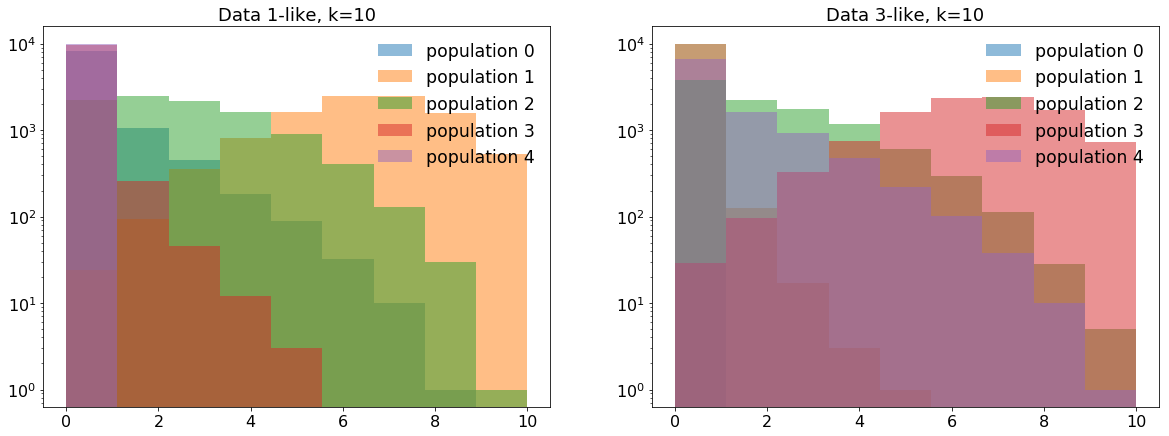

In [190]:
plot_kNN_composition(k=10)

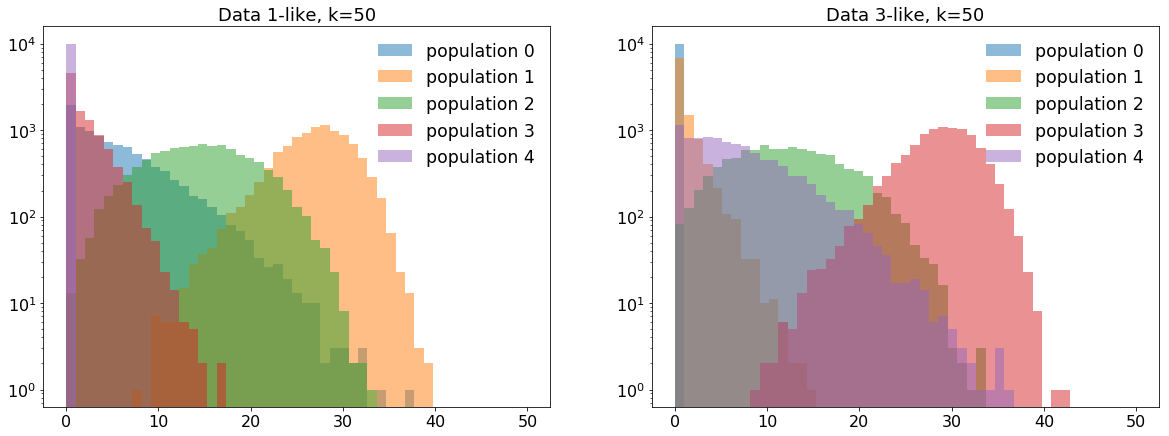

In [191]:
plot_kNN_composition(k=50)

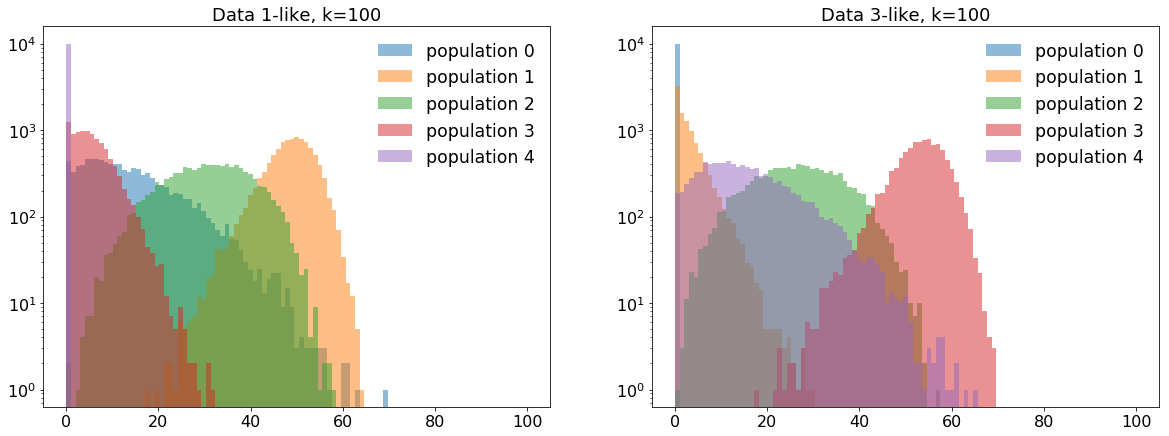

In [192]:
plot_kNN_composition(k=100)